# ScfindME: Mining Alternative Splicing Patterns in Single-cell Atlases

## Example analysis workflow
**Author:**  
Yuyao Song  <ys585@cam.ac.uk>


**Date:**  
May 2022  

## 1. Set up

### 1.1 Install package

In [1]:
# to install the latest release from GitHub
# install.packages("devtools")
# devtools::install_github("hemberg-lab/scfindME", force = TRUE)

In [1]:
library(devtools)
devtools::load_all("/nfs/research/irene/ysong/DATA/SCFIND/scfindME_package/scfindME/")

Loading required package: usethis

ℹ Loading scfindME



Exports from /nfs/research/irene/ysong/DATA/SCFIND/scfindME_package/scfindME/src/eliasFano.cpp:

/nfs/research/irene/ysong/DATA/SCFIND/scfindME_package/scfindME/src/RcppExports.cpp updated.


Re-compiling scfindME



─  installing *source* package ‘scfindME’ ... (340ms)
   ** using staged installation
   ** libs
   x86_64-conda-linux-gnu-c++ -std=gnu++11 -I"/nfs/research/icortes/ysong/anaconda3/envs/maftools/lib/R/include" -DNDEBUG  -I'/nfs/research/icortes/ysong/anaconda3/envs/maftools/lib/R/library/Rcpp/include' -I'/nfs/research/icortes/ysong/anaconda3/envs/maftools/lib/R/library/RcppArmadillo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /nfs/research/icortes/ysong/anaconda3/envs/maftools/include -I/nfs/research/icortes/ysong/anaconda3/envs/maftools/include -Wl,-rpath-link,/nfs/research/icortes/ysong/anaconda3/envs/maftools/lib   -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /nfs/research/icortes/ysong/anaconda3/envs/maftools/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1616773775410/work=/usr/local/src/conda/r-base-4.0.3

### 1.2 Load packages

In [2]:
# load the package scfindME
# also load packages for data manipulation and visulisation
# library(scfindME)
library(tibble)
library(dplyr)
library(tidyr)
library(ggplot2)
library(repr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# a useful function for setting figure size

library(repr)
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

### 1.3 Load example index

In [4]:
# These are the pre-built indices using the Tasic et al.(2016) dataset
# The dataset have detailed subtype classifications of glutamatergic neurons and GABA-ergic neurons in the mouse primary visual cortex

index <- loadObject("../../processed_data/Tasic_2016/tasic_2016_index.rds")

86 MB 
Version 6


In [5]:
# the index is a SCFind class object
class(index)

# the object contains four attributes
slotNames(index)

# the metadata attribute further stores splicing-related information for comprehending the results
## stats stores the mean and SD of the PSI for each node in the index
## node_list stores node related annotations
## diff_cut is a binary matrix to store if the difference of the PSI in a particular pesudobulk and the mean PSI across all pseudobulks is above the cut-off during index building (default 0.2)
## this is to distinguish between PSI = NA (the junction is unquantified), or the PSI of a node is not sufficiently different from dataset mean (PSI ~ mean_PSI) during raw PSI retrieval from index. Both circumstance is treated as 0 in the splicing matrix and compressed during index building

names(index@metadata)

[1] "SCFind"
attr(,"package")
[1] "scfindME"

[1] "index"      "datasets"   "serialized" "metadata"

[1] "stats"     "node_list" "diff_cut"

In [6]:
## the above dataset stores splicing events that has a PSI above tissue average
## the below dataset stores splicing events that has a PSI below tissue average

index@datasets

[1] "above" "below"

In [7]:
## is there a way to split the index by dataset name?

### 1.4 build custom index

In [8]:
## first read in all the matrix generated from running build_matrix_original.R

matrix.above = readRDS("../../processed_data/Tasic_2016/matrix_above.rds")
matrix.below = readRDS("../../processed_data/Tasic_2016/matrix_below.rds")
stats = readRDS("../../processed_data/Tasic_2016/stats.rds")
node.list = readRDS("../../processed_data/Tasic_2016/gene_node_all.rds")
diff.cut = readRDS("../../processed_data/Tasic_2016/diff_cut.rds")
meta = readRDS("../../../original_data/Tasic_2016/pseudobulk_meta.rds")

In [9]:
head(meta)

,pseudo_bulk_ID,samples,primary_type,cell_type,pseudo_bulk_ID_new
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Vip_Mybpc1_1,"SRR2139051,SRR2139022,SRR2138657,SRR2139077,SRR2139043",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_1
2,Vip_Mybpc1_2,"SRR2139035,SRR2138604,SRR2139046,SRR2139057,SRR2140293",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_2
3,Vip_Mybpc1_3,"SRR2139053,SRR2140329,SRR2140337,SRR2139042,SRR2138640",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_3
4,Vip_Mybpc1_4,"SRR2138662,SRR2140291,SRR2140285,SRR2140281,SRR2138955",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_4
5,Vip_Mybpc1_5,"SRR2138646,SRR2139545,SRR2139068,SRR2138643,SRR2138627",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_5
6,Vip_Mybpc1_6,"SRR2138936,SRR2140292,SRR2139028,SRR2140279",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_6


In [10]:
head(matrix.above)

,Vip_Gpc3_8,Pvalb_Wt1_10,L4_Arf5_8,Igtp_2,Sst_Cbln4_7,Vip_Sncg_2,L4_Arf5_6,Micro_Ctss_3,Sst_Cdk6_4,Oligo_Opalin_4,⋯,Vip_Chat_2,Pvalb_Tacr3_12,L5a_Pde1c_3,Pvalb_Gpx3_8,L6a_Sla_7,L2-3_Ptgs2_14,L5b_Tph2_1,Pvalb_Obox3_4,L6a_Sla_10,Pvalb_Wt1_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000048960_51,0.00000,0,0.00000,0,0,0.00000,0,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0,0,0,0.00000,0,0.00000,0,0.00000
ENSMUSG00000048960_52,0.00000,0,0.00000,0,0,0.00000,0,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0,0,0,0.00000,0,0.00000,0,0.00000
ENSMUSG00000048960_53,0.00000,0,0.00000,0,0,0.00000,0,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0,0,0,0.00000,0,0.00000,0,0.00000
ENSMUSG00000048960_54,0.00000,0,0.00000,0,0,0.00000,0,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0,0,0,0.00000,0,0.00000,0,0.00000
ENSMUSG00000048960_55,0.00000,0,0.00000,0,0,0.00000,0,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0,0,0,0.00000,0,0.00000,0,0.00000
ENSMUSG00000026575_22,35.01955,0,35.01955,0,0,35.01955,0,35.01955,35.01955,35.01955,⋯,35.01955,35.01955,0,0,0,35.01955,0,35.01955,0,35.01955


In [11]:
levels(factor(meta$cell_type))

[1] "Astro_Gja1"    "Endo_Myl9"     "Endo_Tbc1d4"   "Igtp"         
 [5] "L2_Ngb"        "L2-3_Ptgs2"    "L4_Arf5"       "L4_Ctxn3"     
 [9] "L4_Scnn1a"     "L5_Chrna6"     "L5_Ucma"       "L5a_Batf3"    
[13] "L5a_Hsd11b1"   "L5a_Pde1c"     "L5a_Tcerg1l"   "L5b_Cdh13"    
[17] "L5b_Tph2"      "L6a_Car12"     "L6a_Mgp"       "L6a_Sla"      
[21] "L6a_Syt17"     "L6b_Rgs12"     "L6b_Serpinb11" "Micro_Ctss"   
[25] "Ndnf_Car4"     "Ndnf_Cxcl14"   "Oligo_96_Rik"  "Oligo_Opalin" 
[29] "OPC_Pdgfra"    "Pvalb_Cpne5"   "Pvalb_Gpx3"    "Pvalb_Obox3"  
[33] "Pvalb_Rspo2"   "Pvalb_Tacr3"   "Pvalb_Tpbg"    "Pvalb_Wt1"    
[37] "Smad3"         "Sncg"          "Sst_Cbln4"     "Sst_Cdk6"     
[41] "Sst_Chodl"     "Sst_Myh8"      "Sst_Tacstd2"   "Sst_Th"       
[45] "Vip_Chat"      "Vip_Gpc3"      "Vip_Mybpc1"    "Vip_Parm1"    
[49] "Vip_Sncg"

In [12]:
meta = meta[match(colnames(matrix.above), meta$pseudo_bulk_ID_new), ]

In [13]:
## make sure that the order of cell in metadata is the same with order of cell in PSI matrix
identical(meta$pseudo_bulk_ID_new, colnames(matrix.above))
identical(meta$pseudo_bulk_ID_new, colnames(matrix.below))

[1] TRUE

[1] TRUE

In [14]:
## build the index for spliced-in events, denoted by 'above' i.e. PSI is above dataset average
idx_above <- buildAltSpliceIndex(psival = matrix.above, metadata = meta, dataset.name = 'above', column.label = 'cell_type', qb = 2)

Generating index for above

	Indexing Astro_Gja1 as above.Astro_Gja1  with  9  cells.

	Indexing Endo_Myl9 as above.Endo_Myl9  with  3  cells.

	Indexing Endo_Tbc1d4 as above.Endo_Tbc1d4  with  3  cells.

	Indexing Igtp as above.Igtp  with  3  cells.

	Indexing L2_Ngb as above.L2_Ngb  with  4  cells.

	Indexing L2-3_Ptgs2 as above.L2-3_Ptgs2  with  19  cells.

	Indexing L4_Arf5 as above.L4_Arf5  with  9  cells.

	Indexing L4_Ctxn3 as above.L4_Ctxn3  with  16  cells.

	Indexing L4_Scnn1a as above.L4_Scnn1a  with  20  cells.

	Indexing L5_Chrna6 as above.L5_Chrna6  with  3  cells.

	Indexing L5_Ucma as above.L5_Ucma  with  3  cells.

	Indexing L5a_Batf3 as above.L5a_Batf3  with  13  cells.

	Indexing L5a_Hsd11b1 as above.L5a_Hsd11b1  with  11  cells.

	Indexing L5a_Pde1c as above.L5a_Pde1c  with  4  cells.

	Indexing L5a_Tcerg1l as above.L5a_Tcerg1l  with  7  cells.

	Indexing L5b_Cdh13 as above.L5b_Cdh13  with  6  cells.

	Indexing L5b_Tph2 as above.L5b_Tph2  with  5  cells.

	Indexing 

In [15]:
## build the index for spliced-out events, denoted by 'below' i.e. PSI is below dataset average
idx_below <- buildAltSpliceIndex(psival = matrix.above, metadata = meta, dataset.name = 'below', column.label = 'cell_type', qb = 2)

Generating index for below

	Indexing Astro_Gja1 as below.Astro_Gja1  with  9  cells.

	Indexing Endo_Myl9 as below.Endo_Myl9  with  3  cells.

	Indexing Endo_Tbc1d4 as below.Endo_Tbc1d4  with  3  cells.

	Indexing Igtp as below.Igtp  with  3  cells.

	Indexing L2_Ngb as below.L2_Ngb  with  4  cells.

	Indexing L2-3_Ptgs2 as below.L2-3_Ptgs2  with  19  cells.

	Indexing L4_Arf5 as below.L4_Arf5  with  9  cells.

	Indexing L4_Ctxn3 as below.L4_Ctxn3  with  16  cells.

	Indexing L4_Scnn1a as below.L4_Scnn1a  with  20  cells.

	Indexing L5_Chrna6 as below.L5_Chrna6  with  3  cells.

	Indexing L5_Ucma as below.L5_Ucma  with  3  cells.

	Indexing L5a_Batf3 as below.L5a_Batf3  with  13  cells.

	Indexing L5a_Hsd11b1 as below.L5a_Hsd11b1  with  11  cells.

	Indexing L5a_Pde1c as below.L5a_Pde1c  with  4  cells.

	Indexing L5a_Tcerg1l as below.L5a_Tcerg1l  with  7  cells.

	Indexing L5b_Cdh13 as below.L5b_Cdh13  with  6  cells.

	Indexing L5b_Tph2 as below.L5b_Tph2  with  5  cells.

	Indexing 

In [16]:
## merge the above and below index to a metaindex object
both <- mergeDataset(idx_above, idx_below)

Merging below



In [17]:
## finally add the metadata to complete the index

index_custom <- addIndexMeta(object = both, stats = stats, node_list = node.list, diff_cut = diff.cut)

In [18]:
class(index_custom)

[1] "SCFind"
attr(,"package")
[1] "scfindME"

## 2. Exploratory analysis

In [19]:
# first, check the encoded cell types
cell_types <- cellTypeNames(index)
cell_types

[1] "above.Astro_Gja1"    "above.Endo_Myl9"     "above.Endo_Tbc1d4"  
 [4] "above.Igtp"          "above.L2_Ngb"        "above.L2-3_Ptgs2"   
 [7] "above.L4_Arf5"       "above.L4_Ctxn3"      "above.L4_Scnn1a"    
[10] "above.L5_Chrna6"     "above.L5_Ucma"       "above.L5a_Batf3"    
[13] "above.L5a_Hsd11b1"   "above.L5a_Pde1c"     "above.L5a_Tcerg1l"  
[16] "above.L5b_Cdh13"     "above.L5b_Tph2"      "above.L6a_Car12"    
[19] "above.L6a_Mgp"       "above.L6a_Sla"       "above.L6a_Syt17"    
[22] "above.L6b_Rgs12"     "above.L6b_Serpinb11" "above.Micro_Ctss"   
[25] "above.Ndnf_Car4"     "above.Ndnf_Cxcl14"   "above.Oligo_96_Rik" 
[28] "above.Oligo_Opalin"  "above.OPC_Pdgfra"    "above.Pvalb_Cpne5"  
[31] "above.Pvalb_Gpx3"    "above.Pvalb_Obox3"   "above.Pvalb_Rspo2"  
[34] "above.Pvalb_Tacr3"   "above.Pvalb_Tpbg"    "above.Pvalb_Wt1"    
[37] "above.Smad3"         "above.Sncg"          "above.Sst_Cbln4"    
[40] "above.Sst_Cdk6"      "above.Sst_Chodl"     "above.Sst_Myh8"     
[43] "above.Sst_Tacstd2"   "above.Sst_Th"        "above.Vip_Chat"     
[46] "above.Vip_Gpc3"      "above.Vip_Mybpc1"    "above.Vip_Parm1"    
[49] "above.Vip_Sncg"      "below.Astro_Gja1"    "below.Endo_Myl9"    
[52] "below.Endo_Tbc1d4"   "below.Igtp"          "below.L2_Ngb"       
[55] "below.L2-3_Ptgs2"    "below.L4_Arf5"       "below.L4_Ctxn3"     
[58] "below.L4_Scnn1a"     "below.L5_Chrna6"     "below.L5_Ucma"      
[61] "below.L5a_Batf3"     "below.L5a_Hsd11b1"   "below.L5a_Pde1c"    
[64] "below.L5a_Tcerg1l"   "below.L5b_Cdh13"     "below.L5b_Tph2"     
[67] "below.L6a_Car12"     "below.L6a_Mgp"       "below.L6a_Sla"      
[70] "below.L6a_Syt17"     "below.L6b_Rgs12"     "below.L6b_Serpinb11"
[73] "below.Micro_Ctss"    "below.Ndnf_Car4"     "below.Ndnf_Cxcl14"  
[76] "below.Oligo_96_Rik"  "below.Oligo_Opalin"  "below.OPC_Pdgfra"   
[79] "below.Pvalb_Cpne5"   "below.Pvalb_Gpx3"    "below.Pvalb_Obox3"  
[82] "below.Pvalb_Rspo2"   "below.Pvalb_Tacr3"   "below.Pvalb_Tpbg"   
[85] "below.Pvalb_Wt1"     "below.Smad3"         "below.Sncg"         
[88] "below.Sst_Cbln4"     "below.Sst_Cdk6"      "below.Sst_Chodl"    
[91] "below.Sst_Myh8"      "below.Sst_Tacstd2"   "below.Sst_Th"       
[94] "below.Vip_Chat"      "below.Vip_Gpc3"      "below.Vip_Mybpc1"   
[97] "below.Vip_Parm1"     "below.Vip_Sncg"

### 2.1 Search marker nodes of an interested cell type

In [20]:
interested_cell_type <- "above.Astro_Gja1"

# rank the splicing nodes by their frequency of inclusion that is above dataset mean in the interested cell type

markers <- cellTypeMarkers(index, interested_cell_type, background.cell.types = cellTypeNames(index, datasets = 'above'), top.k = 10)
markers

nodes,cellType,tp,fp,fn,precision,recall,f1,Gene_id,Node,Coord,Strand,Type,ensembl_gene_id_version,Gene_name,Node_name
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSMUSG00000004980_32,above.Astro_Gja1,8,5,1,0.6153846,0.8888889,0.7272727,ENSMUSG00000004980,32,6:51462056-51462338,-,RI,ENSMUSG00000004980.17,Hnrnpa2b1,Hnrnpa2b1_32
ENSMUSG00000017390_4,above.Astro_Gja1,8,4,1,0.6666667,0.8888889,0.7619048,ENSMUSG00000017390,4,11:78324200-78324325,+,AA,ENSMUSG00000017390.16,Aldoc,Aldoc_4
ENSMUSG00000030235_2,above.Astro_Gja1,9,4,0,0.6923077,1.0000000,0.8181818,ENSMUSG00000030235,2,6:141524535-141524549,+,CE,ENSMUSG00000030235.18,Slco1c1,Slco1c1_2
ENSMUSG00000032826_55,above.Astro_Gja1,7,1,2,0.8749999,0.7777778,0.8235294,ENSMUSG00000032826,55,3:127024774-127024843,-,AD,ENSMUSG00000032826.20,Ank2,Ank2_55
ENSMUSG00000035104_3,above.Astro_Gja1,6,1,3,0.8571429,0.6666667,0.7500001,ENSMUSG00000035104,3,6:82041688-82041834,+,AA,ENSMUSG00000035104.15,Eva1a,Eva1a_3
ENSMUSG00000037196_3,above.Astro_Gja1,8,0,1,1.0000000,0.8888889,0.9411765,ENSMUSG00000037196,3,17:10839761-10839916,-,CE,ENSMUSG00000037196.7,Pacrg,Pacrg_3
ENSMUSG00000060424_10,above.Astro_Gja1,7,3,2,0.7000000,0.7777778,0.7368421,ENSMUSG00000060424,10,1:42666841-42666851,-,AD,ENSMUSG00000060424.15,Pantr1,Pantr1_10
ENSMUSG00000060477_2,above.Astro_Gja1,7,3,2,0.7000000,0.7777778,0.7368421,ENSMUSG00000060477,2,6:113638528-113638641,+,CE,ENSMUSG00000060477.15,Irak2,Irak2_2
ENSMUSG00000061080_25,above.Astro_Gja1,9,3,0,0.7500000,1.0000000,0.8571428,ENSMUSG00000061080,25,16:42144025-42144085,+,CE,ENSMUSG00000061080.12,Lsamp,Lsamp_25


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'genes' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(o

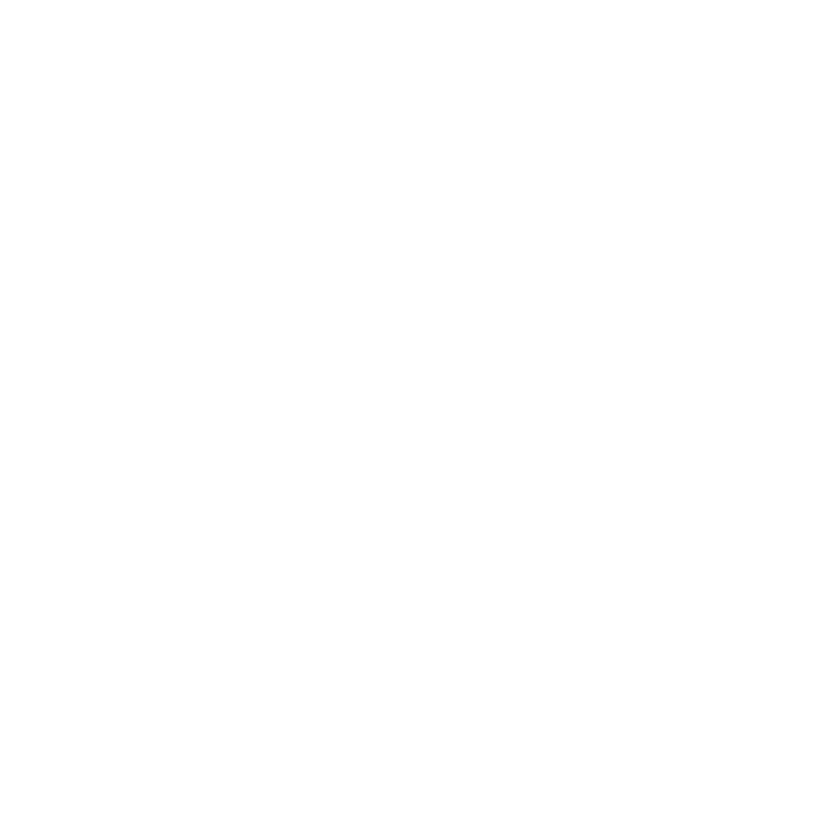

In [21]:
# plot the nodes using their precision. recall and f1 scores to examine

ggplot(markers, aes(x = precision, y = recall, colour = f1, label = genes)) +
theme_bw() + 
geom_point(aes(size = f1)) +
geom_text(vjust = 0, 
          nudge_y = 0.01, 
          colour = "black", 
          check_overlap = T) +
xlim(0.4, 1.2)

fig(6, 6)

In [22]:
## get the annotations of query nodes
## use the markers of interested cell type as example
nodeDetails(index, as.character(markers$genes))

,Gene_id,Node,Coord,Strand,Type,ensembl_gene_id_version,Gene_name,Node_id,Node_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
298236,ENSMUSG00000037196,3,17:10839761-10839916,-,CE,ENSMUSG00000037196.7,Pacrg,ENSMUSG00000037196_3,Pacrg_3
431117,ENSMUSG00000061080,25,16:42144025-42144085,+,CE,ENSMUSG00000061080.12,Lsamp,ENSMUSG00000061080_25,Lsamp_25
431113,ENSMUSG00000061080,26,16:42144552-42144700,+,CE,ENSMUSG00000061080.12,Lsamp,ENSMUSG00000061080_26,Lsamp_26
254878,ENSMUSG00000032826,55,3:127024774-127024843,-,AD,ENSMUSG00000032826.20,Ank2,ENSMUSG00000032826_55,Ank2_55
215563,ENSMUSG00000030235,2,6:141524535-141524549,+,CE,ENSMUSG00000030235.18,Slco1c1,ENSMUSG00000030235_2,Slco1c1_2
48707,ENSMUSG00000017390,4,11:78324200-78324325,+,AA,ENSMUSG00000017390.16,Aldoc,ENSMUSG00000017390_4,Aldoc_4
278684,ENSMUSG00000035104,3,6:82041688-82041834,+,AA,ENSMUSG00000035104.15,Eva1a,ENSMUSG00000035104_3,Eva1a_3
428838,ENSMUSG00000060424,10,1:42666841-42666851,-,AD,ENSMUSG00000060424.15,Pantr1,ENSMUSG00000060424_10,Pantr1_10
429103,ENSMUSG00000060477,2,6:113638528-113638641,+,CE,ENSMUSG00000060477.15,Irak2,ENSMUSG00000060477_2,Irak2_2


### 2.2 Search cell types enriched in an interested splicing event

In [23]:
# find all nodes in a particular gene

Gria2_nodes <- geneNodes(index, "Gria2", "Gene_name")
Gria2_nodes <- Gria2_nodes[order(as.numeric(as.character(Gria2_nodes$Node))), ]
Gria2_nodes

,Gene_id,Node,Coord,Strand,Type,ensembl_gene_id_version,Gene_name,Node_id,Node_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
265697,ENSMUSG00000033981,3,3:80802580-80802650,-,AA,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_3,Gria2_3
265702,ENSMUSG00000033981,4,3:80802297-80802579,-,CE,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_4,Gria2_4
265695,ENSMUSG00000033981,5,3:80801648-80801785,-,NA,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_5,Gria2_5
265708,ENSMUSG00000033981,6,3:80801645-80801647,-,NA,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_6,Gria2_6
265710,ENSMUSG00000033981,7,3:80800036-80801644,-,AD,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_7,Gria2_7
265701,ENSMUSG00000033981,21,3:80706888-80707063,-,AD,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_21,Gria2_21
265704,ENSMUSG00000033981,22,3:80706353-80706887,-,AD,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_22,Gria2_22
265711,ENSMUSG00000033981,25,3:80692285-80692532,-,CE,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_25,Gria2_25
265707,ENSMUSG00000033981,26,3:80691744-80692284,-,RI,ENSMUSG00000033981.15,Gria2,ENSMUSG00000033981_26,Gria2_26


In [24]:
# query significant cell types by a specific splicing event
## accept logical operators: prepend "-" means node exclusion

Gria2_mxe <- c("ENSMUSG00000033981_28", "ENSMUSG00000033981_29")
hyperQueryCellTypes(index, c("ENSMUSG00000033981_28", "-ENSMUSG00000033981_29"), datasets = 'above') %>% arrange(pval)

Found 124 cell expressing ENSMUSG00000033981_28

Excluded 4 cells expressing ENSMUSG00000033981_29



cell_type,cell_hits,total_cells,pval
<chr>,<int>,<dbl>,<dbl>
above.Igtp,3,3,0.0000000
above.Pvalb_Obox3,4,4,0.0000000
above.Pvalb_Wt1,11,11,0.0000000
above.Smad3,3,3,0.0000000
above.Vip_Sncg,3,3,0.0000000
above.L4_Arf5,8,9,0.2292646
above.Sst_Myh8,7,8,0.4080985
above.Ndnf_Cxcl14,6,7,0.7231381
above.Astro_Gja1,1,9,1.0000000


### 3. Retrieve actual PSI for discovered splicing patterns

In [25]:
## check the raw PSI value of query nodes in particular cell types, return a dataframe with cell type, node raw PSI and node details

raw_psi = getRawPsi(object = index, node.list = Gria2_mxe, cell.types = gsub("above\\.", "", cellTypeNames(index, datasets = 'above')))
head(raw_psi)

Astro_Gja1

Added Astro_Gja1

Endo_Myl9

Added Endo_Myl9

Endo_Tbc1d4

Added Endo_Tbc1d4

Igtp

Added Igtp

L2_Ngb

Added L2_Ngb

L2-3_Ptgs2

Added L2-3_Ptgs2

L4_Arf5

Added L4_Arf5

L4_Ctxn3

Added L4_Ctxn3

L4_Scnn1a

Added L4_Scnn1a

L5_Chrna6

Added L5_Chrna6

L5_Ucma

Added L5_Ucma

L5a_Batf3

Added L5a_Batf3

L5a_Hsd11b1

Added L5a_Hsd11b1

L5a_Pde1c

Added L5a_Pde1c

L5a_Tcerg1l

Added L5a_Tcerg1l

L5b_Cdh13

Added L5b_Cdh13

L5b_Tph2

Added L5b_Tph2

L6a_Car12

Added L6a_Car12

L6a_Mgp

Added L6a_Mgp

L6a_Sla

Added L6a_Sla

L6a_Syt17

Added L6a_Syt17

L6b_Rgs12

Added L6b_Rgs12

L6b_Serpinb11

Added L6b_Serpinb11

Micro_Ctss

Added Micro_Ctss

Ndnf_Car4

Added Ndnf_Car4

Ndnf_Cxcl14

Added Ndnf_Cxcl14

Oligo_96_Rik

Added Oligo_96_Rik

Oligo_Opalin

Added Oligo_Opalin

OPC_Pdgfra

Added OPC_Pdgfra

Pvalb_Cpne5

Added Pvalb_Cpne5

Pvalb_Gpx3

Added Pvalb_Gpx3

Pvalb_Obox3

Added Pvalb_Obox3

Pvalb_Rspo2

Added Pvalb_Rspo2

Pvalb_Tacr3

Added Pvalb_Tacr3

Pvalb_Tpbg

Added Pval

,Node_id,Cell_id,raw_psi,Gene_id,Node,Coord,Strand,Type,ensembl_gene_id_version,Gene_name,Node_name
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000033981_28,Astro_Gja1_1,1,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28
2,ENSMUSG00000033981_28,Astro_Gja1_2,NA,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28
3,ENSMUSG00000033981_28,Astro_Gja1_3,1,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28
4,ENSMUSG00000033981_28,Astro_Gja1_4,1,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28
5,ENSMUSG00000033981_28,Astro_Gja1_5,NA,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28
6,ENSMUSG00000033981_28,Astro_Gja1_6,NA,ENSMUSG00000033981,28,3:80691521-80691702,-,AD,ENSMUSG00000033981.15,Gria2,Gria2_28


### 4. Heatmap of PSI value of a splicing pattern

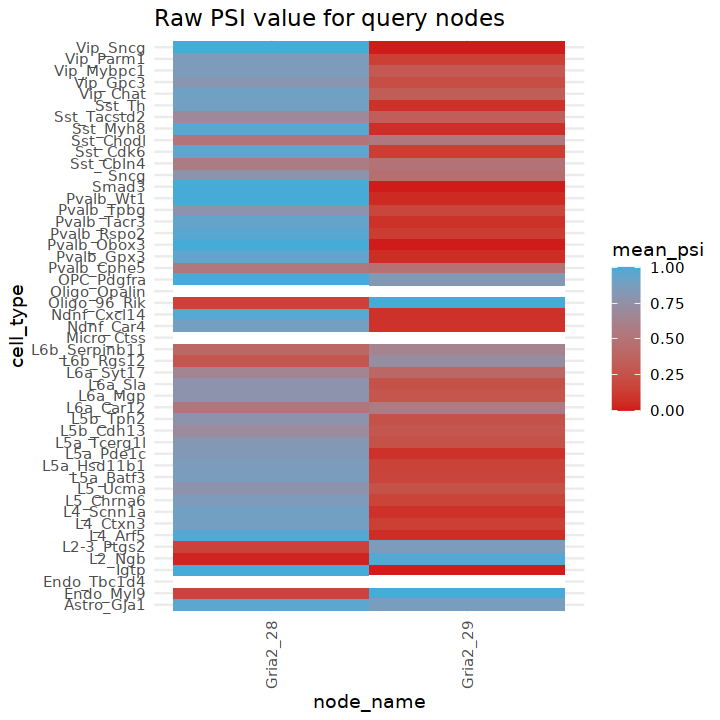

In [26]:
## generate a heatmap for raw PSI values

plotRawPsiHeatmap(raw_psi = raw_psi, node.list = Gria2_mxe, cell.types = gsub("above\\.", "", cellTypeNames(index, datasets = 'above')))

fig(6, 10)

In [27]:
## find nodes with a similar splcing pattern with query nodes

findSimilarNodes(object = index, node.list = Gria2_mxe[1], datasets = 'above', top.k = 10)

Searching for genes with similar pattern...



  |======================================================================| 100%


gene,Jaccard,overlap,n
<chr>,<dbl>,<dbl>,<dbl>
ENSMUSG00000026554_38,0.3565217,82,188
ENSMUSG00000009681_31,0.3571429,80,180
ENSMUSG00000050587_2,0.3571429,75,161
ENSMUSG00000032479_18,0.3628319,82,184
ENSMUSG00000037492_3,0.3631841,73,150
ENSMUSG00000061751_100,0.3641304,67,127
ENSMUSG00000044647_21,0.3647059,62,108
ENSMUSG00000002280_25,0.3750000,81,173
ENSMUSG00000066392_38,0.3811881,77,155


In [28]:
above_glul5 = cell_types[grep("above\\.L5", cell_types)]

In [29]:
above_glul5

[1] "above.L5_Chrna6"   "above.L5_Ucma"     "above.L5a_Batf3"  
[4] "above.L5a_Hsd11b1" "above.L5a_Pde1c"   "above.L5a_Tcerg1l"
[7] "above.L5b_Cdh13"   "above.L5b_Tph2"

In [30]:
# find house keeping nodes in a particular group of cell types
## use L5 glutamatergic neurons as example

above_glul5_nodes = findHouseKeepingNodes(object = index, cell.types = above_glul5)
above_glul5_nodes

Searching for house keeping node...



  |======================================================================| 100%


[1] "ENSMUSG00000002825_7"  "ENSMUSG00000023960_2"  "ENSMUSG00000001211_34"
[4] "ENSMUSG00000007739_4"  "ENSMUSG00000019951_38" "ENSMUSG00000020111_21"

In [31]:
nodeDetails(object = index, node.list = above_glul5_nodes)

,Gene_id,Node,Coord,Strand,Type,ensembl_gene_id_version,Gene_name,Node_id,Node_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
13004,ENSMUSG00000002825,7,9:21412233-21412301,+,CE,ENSMUSG00000002825.9,Qtrt1,ENSMUSG00000002825_7,Qtrt1_7
115379,ENSMUSG00000023960,2,17:44078899-44078982,+,AD,ENSMUSG00000023960.14,Enpp5,ENSMUSG00000023960_2,Enpp5_2
5450,ENSMUSG00000001211,34,10:78282477-78283094,-,RI,ENSMUSG00000001211.16,Agpat3,ENSMUSG00000001211_34,Agpat3_34
30845,ENSMUSG00000007739,4,11:22993267-22993319,+,CE,ENSMUSG00000007739.11,Cct4,ENSMUSG00000007739_4,Cct4_4
60233,ENSMUSG00000019951,38,10:89818183-89818288,+,AD,ENSMUSG00000019951.11,Uhrf1bp1l,ENSMUSG00000019951_38,Uhrf1bp1l_38
62735,ENSMUSG00000020111,21,10:59762413-59762656,+,CE,ENSMUSG00000020111.16,Micu1,ENSMUSG00000020111_21,Micu1_21


In [32]:
## find signature splicing events for particular cell types

findNodeSignatures(object = index, cell.types = above_glul5)

Searching for node signatures...



  |======================================================================| 100%


$above.L5a_Batf3
[1] "ENSMUSG00000016763_29" "ENSMUSG00000017493_15" "ENSMUSG00000024646_1" 
[4] "ENSMUSG00000025289_3"  "ENSMUSG00000025393_28" "ENSMUSG00000029672_17"
[7] "ENSMUSG00000037624_21"

$above.L5a_Hsd11b1
[1] "ENSMUSG00000024505_11" "ENSMUSG00000026514_12" "ENSMUSG00000032336_9" 
[4] "ENSMUSG00000037624_21" "ENSMUSG00000045671_11" "ENSMUSG00000066392_35"

In [33]:
## find all cells per cell type that express the full set of nodes in gene.list

findCellTypes(object = index, gene.list = Gria2_mxe[1], datasets = 'above')

$above.Pvalb_Gpx3
 [1]  1  2  3  5  6  7  8  9 10 12

$above.OPC_Pdgfra
[1] 4

$above.Ndnf_Cxcl14
[1] 1 2 3 4 5 6

$above.L4_Arf5
[1] 1 2 3 4 5 6 7 8

$above.L5a_Tcerg1l
[1] 1

$above.L5a_Pde1c
[1] 2

$above.Ndnf_Car4
[1] 1 2 6

$above.L4_Scnn1a
 [1]  1  2  3  4  5  7  8 11 15 16 18

$above.Pvalb_Tacr3
[1]  1  2  4  5  7  9 10 12 13

$above.L5a_Batf3
[1]  3  5  7 10 12

$above.L5_Chrna6
[1] 2

$above.Vip_Parm1
[1] 1 3 5

$above.Astro_Gja1
[1] 1 3 4 8

$above.L4_Ctxn3
[1]  3  4  7  8 11 13 15 16

$above.L5a_Hsd11b1
[1]  3  4  6 10

$above.Igtp
[1] 1 2 3

$above.Pvalb_Obox3
[1] 1 2 3 4

$above.Smad3
[1] 1 2 3

$above.Sst_Th
[1] 1 2

$above.Pvalb_Wt1
 [1]  1  2  3  4  5  6  7  8  9 10 11

$above.Sst_Myh8
[1] 1 2 3 4 5 6 8

$above.Sst_Cdk6
[1] 2 3 4

$above.Vip_Chat
[1]  4  5  6  9 10

$above.Vip_Gpc3
[1] 4

$above.Vip_Sncg
[1] 1 2 3

$above.Vip_Mybpc1
[1] 1 5

$above.Pvalb_Rspo2
[1] 1 2 4 5 6

## TODO
## long query optimization routine

markerNodes(object = index, gene.list = c(Gria2_nodes$Node_id), datasets = c('above'))

In [34]:
markerNodes(object = index, gene.list = c(Gria2_nodes$Node_id))

## should take dataset input

calculating tfidf for the reduced expression matrix... 


Genes,Query,tfidf,Cells
<int>,<chr>,<dbl>,<int>
2,"ENSMUSG00000033981_21,ENSMUSG00000033981_25",0.03138982,48
3,"ENSMUSG00000033981_21,ENSMUSG00000033981_25,ENSMUSG00000033981_26",0.04636023,47
4,"ENSMUSG00000033981_21,ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_28",0.06032532,23
4,"ENSMUSG00000033981_21,ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_29",0.06263539,9
3,"ENSMUSG00000033981_21,ENSMUSG00000033981_25,ENSMUSG00000033981_28",0.04555008,24
3,"ENSMUSG00000033981_21,ENSMUSG00000033981_25,ENSMUSG00000033981_29",0.04766498,9
2,"ENSMUSG00000033981_21,ENSMUSG00000033981_26",0.03143161,51
3,"ENSMUSG00000033981_21,ENSMUSG00000033981_26,ENSMUSG00000033981_28",0.04556339,24
3,"ENSMUSG00000033981_21,ENSMUSG00000033981_26,ENSMUSG00000033981_29",0.04772144,10


In [36]:
getCoordinatedNodes(object = index, gene.name = 'Gria2')

## should take dataset input

calculating tfidf for the reduced expression matrix... 


Genes,Query,tfidf,Cells
<int>,<chr>,<dbl>,<int>
4,"ENSMUSG00000033981_22,ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_7",0.06030977,6
4,"ENSMUSG00000033981_21,ENSMUSG00000033981_29,ENSMUSG00000033981_31,ENSMUSG00000033981_4",0.05362449,6
4,"ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_29,ENSMUSG00000033981_4",0.04935919,6
3,"ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_33",0.04986312,6
3,"ENSMUSG00000033981_25,ENSMUSG00000033981_26,ENSMUSG00000033981_32",0.04906834,6
3,"ENSMUSG00000033981_22,ENSMUSG00000033981_25,ENSMUSG00000033981_7",0.04553755,6


In [48]:
findNodeSets(object = index, gene.list = c("Golgb1"), query.type = 'Gene_name', node.types = c("CE", "AA", 'AD', 'RI', NA))

## should take dataset input

calculating tfidf for the reduced expression matrix... 


running hyperQueryCellType using



[1] "ENSMUSG00000034243_7" "ENSMUSG00000034243_8" "ENSMUSG00000034243_9"
            cell_type cell_hits total_cells      pval
1    above.Astro_Gja1         2           9 1.0000000
2     above.Endo_Myl9         2           3 0.6700576
3   above.Endo_Tbc1d4         2           3 0.6700576
4          above.Igtp         1           3 1.0000000
5    above.L2-3_Ptgs2         2          19 1.0000000
6       above.L4_Arf5         1           9 1.0000000
7      above.L4_Ctxn3         5          16 1.0000000
8     above.L4_Scnn1a         3          20 1.0000000
9     above.L5_Chrna6         2           3 0.6700576
10    above.L5a_Batf3         1          13 1.0000000
11  above.L5a_Hsd11b1         2          11 1.0000000
12  above.L5a_Tcerg1l         1           7 1.0000000
13    above.L5b_Cdh13         1           6 1.0000000
14      above.L6a_Mgp         1           8 1.0000000
15   above.Micro_Ctss         4           4 0.0000000
16 above.Oligo_96_Rik         1           3 1.0000000
17 above.

find a cell type specific node set 




[1] "ENSMUSG00000034243_7" "ENSMUSG00000034243_8" "ENSMUSG00000034243_9"


,cell_type,cell_hits,total_cells,pval
,<chr>,<int>,<dbl>,<dbl>
15,above.Micro_Ctss,4,4,0


In [87]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /nfs/research/icortes/ysong/anaconda3/envs/maftools/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scfindME_0.1.0 repr_1.1.3     tidyr_1.2.0    dplyr_1.0.8    tibble_3.1.6  
[6] ggpubr_0.4.0   ggplot2_3.3.5 

loaded via a namespace (and not attached):
  [1] colorspace_2.0-3     ggsignif_0.6.3       ellipsis_0.3.2      
  [4] rprojroot_2.0.2      IRdisplay_1.0        htmlTable_2.4.0   